<center>
    
# 3D Stencil-Filter in python
## python | jupyter | numba/CUDA | openPMD-API
   
</center>

supervisor:
 - Richard Pausch (`r.pausch@hzdr.de`)
 - Matthias Werner (`m.werner@hzdr.de`) - probably not available till the end of the course
 - Alexander Debus (`a.debus@hzdr.de`) - in case I am not available 

## Python

Do you know python?

```python
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-5, 5, 1024)
y = np.sin(x)

plt.plot(x,y)
plt.show()
```

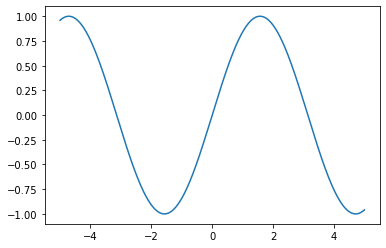

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-5, 5, 1024)
y = np.sin(x)

plt.plot(x,y)
plt.show()

## Learning python

- well documented online: www.python.org
- free online courses: e.g.: www.sololearn.com or software-carpentry.org (older versions)
- various well supported and documented modules [`numpy`](https://numpy.org ), [`matplotlib`](https://matplotlib.org ), etc.

## Jupyter

Did you use the taurus **jupyterhub** before?

**Web access:**
https://taurus.hrsk.tu-dresden.de/jupyter

**wiki page:**
https://doc.zih.tu-dresden.de/hpc-wiki/bin/view/Compendium/JupyterHub

**Problem:** be default, `numba` is not supported 

## Jupyter - own environment 1/6 - go on k80 node
```bash
# login to k80
srun --pty -p gpu2-interactive -n 1 -c 2 --mem-per-cpu 1000 --gres=gpu:1 
    -t 08:00:00 bash -l


# load anaconda
module load Anaconda3

# load CUDA
module load CUDA

```

## Jupyter - own environment 2/6 - create env
```bash
# create env dir
mkdir user-kernel-jupyterLab

# create env
conda create --prefix /home/<username>/user-kernel-jupyterLab/k80_numba python=3.6

# set shell
conda init bash
```

## Jupyter - own environment 3/6 - activate env
```bash
# restart shell/interactive session
#doent forget to load CUDA
module load CUDA

# active env
conda activate /home/<username>/user-kernel-jupyterLab/k80_numba/
```

## Jupyter - own environment 4/6 - name kernel
```bash
# install ipythen kernel
conda install ipykernel

# activate and name new kernel
 python -m ipykernel install --user --name k80_numba --display-name="k80_numba"
```

## Jupyter - own environment 5/6 - install numba
```bash
# install numba
conda install numba

# install CUDA toolkit (required for GPU support)
conda install cudatoolkit
```

## Jupyter - own environment 6/6 - other modules
```bash
# install other modules
conda install numpy
conda install scipy
conda install matplotlib
conda install -c conda-forge openpmd-api
conda install -c conda-forge h5py
conda install -c conda-forge adios-python

```

## Numba

Numba is a high performance python compiler using **function decorators**.

see https://numba.pydata.org 

```python
@decorator
def func(x):
    ...
```

In [2]:
import numba 
import numpy as np

@numba.jit # just in time decorator
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

In [3]:
import time

data = np.random.random((512, 256))

start = time.time()
data_sum = sum2d(data)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

start = time.time()
data_sum = sum2d(data)
end = time.time()
print("Elapsed (without compilation) = %s" % (end - start))

Elapsed (with compilation) = 0.3385579586029053
Elapsed (without compilation) = 0.000244140625


## Numba - CPU JIT compiler summary 

- just add `@numba.jit` decorator
- first function call (with specific arguments types) will trigger compilation
- after that, no extra time for compilation needed
- best practice for CPU: 


```python
from numba import jit

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def function(...)
   ...
```

## Numba - GPU programming with CUDA

- load CUDA JIT:

```python
from numba import cuda
```

- tread and block IDs are part of the `cuda` module: 

```python
cuda.threadIdx.x
cuda.blockIdx.y
...
```

- kernel call 

```python
kernel_function[(blocks, blocks), (threads, threads)](arguments)

```

In [4]:
# load needed modules

import numpy as np
from numba import cuda
from math import ceil 

In [5]:
# define simple matrix multiplication kernel
# as done already in C++/CUDA

@cuda.jit
def matmul(a, b, c, dim):
    row = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x;
    col = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y;
    if row < dim and col < dim:
        sum = 0
        for k in range(dim):
            sum += a[row*dim+k] * b[k*dim+col]
        c[row*dim+col] = sum

In [6]:
# create data:

# define size
dim = 2048*2

# 1st matrix
a_original = np.zeros((dim,dim), dtype=np.float32)
for i in range(dim):
    a_original[i,i] = 1 # create unite matrix
a = a_original.flatten()

# 2nd matrix
b_original = np.float32(np.random.normal(size=(dim,dim)))
b = b_original.flatten()

# result matrix
c = np.zeros((dim*dim), dtype=np.float32)

In [7]:
# define threads and blocks
threads = 32
blocks = ceil(dim/threads)

start = time.time()
# call CUDA kernel
matmul[(blocks, blocks), (threads, threads)](a, b, c, dim)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 14.085613250732422


In [8]:
# run code on CPU using numpy matric multiplication
start = time.time()
c_cpu = np.dot(a_original, b_original)
end = time.time()
print("Elapsed (numpy) = %s" % (end - start))

if (c == c_cpu.ravel()).all():
    print("Congratulations!")
else:
    print("The results are not equals :-(")

Elapsed (numpy) = 1.6387245655059814
Congratulations!


In [9]:
tile_size = 32

@cuda.jit
def matmul_sm(A, B, C, dim):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    aBegin = dim * tile_size * by;
    aEnd = aBegin + dim -1
    aStep = tile_size
    
    bBegin = tile_size * bx
    bStep = tile_size * dim
    
    sum = 0
    
    a = aBegin
    b = bBegin
    while a <= aEnd:
        As = cuda.shared.array(shape=(tile_size, tile_size), dtype=numba.float32)
        Bs = cuda.shared.array(shape=(tile_size, tile_size), dtype=numba.float32)
        
        As[ty][tx] = A[a + dim * ty + tx]
        Bs[ty][tx] = B[b + dim * ty + tx]
        
        cuda.syncthreads()
        
        for k in range(tile_size):
            sum += As[ty][k] * Bs[k][tx]
            
        cuda.syncthreads()
        
        a += aStep
        b += bStep
    
    c = dim * tile_size * by + tile_size * bx
    C[c + dim * ty + tx] = sum

In [10]:
c = np.zeros(dim*dim)

start = time.time()
# call CUDA kernel
matmul_sm[(blocks, blocks), (threads, threads)](a, b, c, dim)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

if (c == c_cpu.ravel()).all():
    print("Congratulations!")
else:
    print("The results are not equals :-(")

Elapsed (with compilation) = 0.9493758678436279
Congratulations!


## Numba CUDA - summary

- define kernels via `@numba.cuda` decorator
- use of shared memory is recomanded for data intensive tasks
- algorithmic approch very similar to what you learned so far with C++/CUDA
- memcopy not directly called

## openPMD-API

[openPMD](https://www.openpmd.org) is am open meta-data standard for particle mash data as used e.g. by particle-in-cell simulations 

It defines how data is structured in [HDF5](https://www.hdfgroup.org/solutions/hdf5) or [ADIOS](https://www.olcf.ornl.gov/center-projects/adios/) files.

For this project, you will only need to interact with the [openPMD-API](https://openpmd-api.readthedocs.io/en/latest/). 

get example data set:

```bash
wget https://github.com/openPMD/openPMD-example-datasets/raw/draft/example-3d.tar.gz

tar -xvzf example-3d.tar.gz
```

In [11]:
import openpmd_api as api

import numpy as np

In [12]:
# access data

path = "openPMD_api/example-3d/hdf5/"
series = api.Series(
    path + "data%T.h5", 
    api.Access_Type.read_only)

[26, 26, 201]


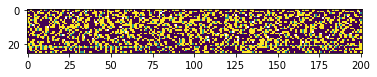

In [13]:
i = series.iterations[500]

# record
E = i.meshes["E"]

# record components
E_x = E["x"]

print(np.shape(E_x))

plt.imshow(E_x[13, :, :])

## Basic concept of the stencil code

generate random data

In [14]:
data = np.random.rand(5,6)

plot that data

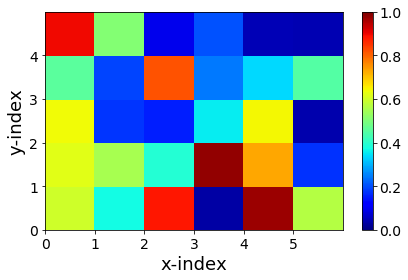

In [15]:
plt.pcolormesh(data, cmap=plt.cm.jet, vmin=0.0, vmax=1.0)
plt.xlabel("x-index", fontsize=18)
plt.xticks([0,1,2,3,4,5], fontsize=14)
plt.ylabel("y-index", fontsize=18)
plt.yticks([0,1,2,3,4], fontsize=14)

cb = plt.colorbar()
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)

plt.tight_layout()
plt.show()

### illustrate simple 2D stencil

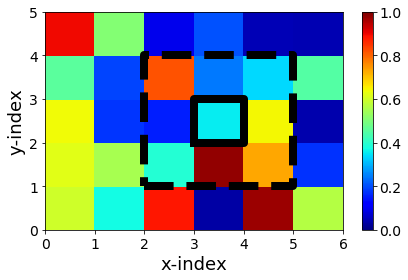

In [16]:
plt.pcolormesh(data, cmap=plt.cm.jet, vmin=0.0, vmax=1.0)
plt.xlabel("x-index", fontsize=18)
plt.xticks([0,1,2,3,4,5,6], fontsize=14)
plt.ylabel("y-index", fontsize=18)
plt.yticks([0,1,2,3,4,5], fontsize=14)

plt.plot([2,5,5,2,2],[1,1,4,4,1], "--", color="black", lw=8)

plt.plot([3,4,4,3,3],[2,2,3,3,2], "-", color="black", lw=8)


cb = plt.colorbar()
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)

plt.tight_layout()
plt.show()

### apply stencil for one/selected value

In [17]:
data2 = data.copy() # output data
data2[2,3] = np.median(data[1:4,2:5])

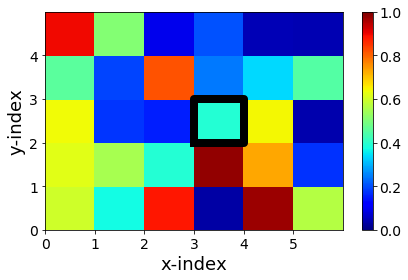

In [18]:
plt.pcolormesh(data2, cmap=plt.cm.jet, vmin=0.0, vmax=1.0)
plt.xlabel("x-index", fontsize=18)
plt.xticks([0,1,2,3,4,5], fontsize=14)
plt.ylabel("y-index", fontsize=18)
plt.yticks([0,1,2,3,4], fontsize=14)

plt.plot([3,4,4,3,3],[2,2,3,3,2], "-", color="black", lw=8)

cb = plt.colorbar()
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)

plt.tight_layout()
plt.show()

### run simple stencil on all data

In [19]:
data3 = np.empty_like(data) # output data

Ny, Nx = np.shape(data)

for x_id in range(Nx):
    x_min = max(x_id-1, 0)
    x_max = min(x_id+2, Nx)
    for y_id in range(Ny):
        y_min = max(y_id-1, 0)
        y_max = min(y_id+2, Ny)
        
        data3[y_id, x_id] = np.median(data[y_min:y_max, x_min:x_max])

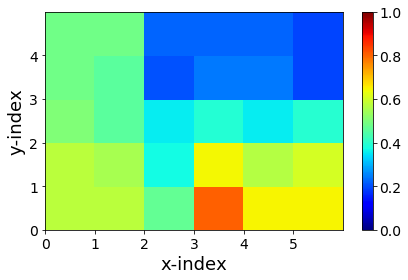

In [20]:
plt.pcolormesh(data3, cmap=plt.cm.jet, vmin=0.0, vmax=1.0)
plt.xlabel("x-index", fontsize=18)
plt.xticks([0,1,2,3,4,5], fontsize=14)
plt.ylabel("y-index", fontsize=18)
plt.yticks([0,1,2,3,4], fontsize=14)

cb = plt.colorbar()
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)

plt.tight_layout()
plt.show()

### apply to large 3D data set
generate that data set

In [21]:
Nz, Ny, Nx = 128, 512, 128

real_data = (np.ones((Nz, Ny, Nx)) * np.sin(np.linspace(0, 20, Ny)[np.newaxis, :, np.newaxis])*0.5 
             + np.random.normal(scale=1.0, size=(Nz, Ny, Nx)) )

plot a slice of the data

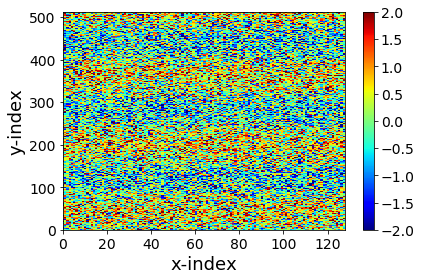

In [22]:
plt.pcolormesh(real_data[Nz//2,:, :], vmin=-2, vmax=2, cmap=plt.cm.jet)

cb = plt.colorbar()
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)
    
plt.xlabel("x-index", fontsize=18)
plt.xticks( fontsize=14)
plt.ylabel("y-index", fontsize=18)
plt.yticks( fontsize=14)

plt.tight_layout()

plt.show()

### define stencil function

In [23]:
@numba.njit
def cpu_smooth_kernel(input_data, output_data, fkt, stencil):
    # data size
    Nz, Ny, Nx = np.shape(input_data)
    # stencil size
    dx = stencil[0]
    dy = stencil[1]
    dz = stencil[2]
    # run over all data
    for z_id in range(Nz):
        z_min = max(z_id-dz, 0)
        z_max = min(z_id+dz+1, Nz)
        for y_id in range(Ny):
            y_min = max(y_id-dy, 0)
            y_max = min(y_id+dy+1, Ny)
            for x_id in range(Nx):
                x_min = max(x_id-dx, 0)
                x_max = min(x_id+dx+1, Nx)

                output_data[z_id, y_id, x_id] = fkt(input_data[z_min:z_max, y_min:y_max, x_min:x_max])

### apply stencil function on 3D data set

In [24]:
real_data2 = real_data.copy()
stencil = (8, 6, 8)

@numba.njit
def numba_median(array):
    return np.median(array)

In [25]:
start = time.time()
cpu_smooth_kernel(real_data, real_data2, numba_median, stencil)
end = time.time()
print("Elapsed (numpy) = %s" % (end - start))

Elapsed (numpy) = 356.6800105571747


plot smoothed data

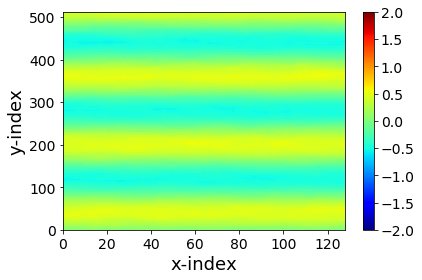

In [26]:
plt.pcolormesh(real_data2[Nz//2,:, :], vmin=-2, vmax=2, cmap=plt.cm.jet)

cb = plt.colorbar()
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)
    
plt.xlabel("x-index", fontsize=18)
plt.xticks( fontsize=14)
plt.ylabel("y-index", fontsize=18)
plt.yticks( fontsize=14)

plt.tight_layout()
plt.show()

# End